# IS362 Final Project
## Data analysis of the US Energy Information Administration (EIA)
### Anthony Paveglio
---
The EIA is a federal agency associated witht he US Department of Energy. The EIA is responsible for collecting data regarding various forms of energy in the US including fossil fuels, renewable energy, and a global outlook on energy and its impact. The usage, production, and transportation of forms of energy are tracked through the EIA.

- Fossil Fuel: A natural form of energy such as coal, gas, or oil.
- Renewable Energy: Also a natural form of energy collected from sources quicker to replenish such as solar, wind, or hydroelectric.

_More info will appear here, in progress..._

---

# 1. Libraries and Imported files

In [179]:
#Necessary libraries and imports
import sys
import requests
import json
import pandas
import seaborn
import numpy
import datetime
import matplotlib
import matplotlib.pyplot

# 2. API Access Request and Handling
## Making a connection with US EIA data sources.

In [180]:
categoryData = requests.get(
    "http://api.eia.gov/category/?api_key=ba1598e22a90a4bb48e3c5bdc55db041&category_id=371&out=json")

print 'Response code from EIA API:', categoryData.status_code, categoryData.reason
print 'Amount of time required for request:', categoryData.elapsed

Response code from EIA API: 200 OK
Amount of time required for request: 0:00:00.133510


## Functions to convert EIA data to usable Python data

In [181]:
def JSONtoDataFrameEIA(APIResponse, columnTitles=None):
    #Takes the returned data from the API call and converts it into a usable dataframe
    #EIA responses contain the actual data and a list of headers embedded in JSON
    #Also converts all string date data to a usable datetime
    #The EIA structures their dates as 'yyyymm'
    #Example: 202001 = 2020/1 = January 2020

    #Parameters:
    #    APIResponse (mixed): The API response to be parsed into a DataFrame.
    #    columnTitles (list, optional): List of column titles to apply over the Dataframe's columns
    #         if the columnTitles are not specified in the function call, default titles will be
    #         assigned based on the data within the returned API call data

    #Returns:
    #    EIADataFrame(DataFrame): EIA Data parsed into a Dataframe
    
    EIADataFrame = pandas.DataFrame(APIResponse.json()['series'][0]['data'])
    if columnTitles:
        EIADataFrame.columns = columnTitles
    else:
        EIADataFrame.columns = ['Date', APIResponse.json()['series'][0]['name']]
    EIADataFrame['Date'] = pandas.to_datetime(EIADataFrame['Date'], format='%Y%m')
    return EIADataFrame

def JSONheadersEIA(APIResponse):
    headerData = APIResponse.json()['series'][0]
    return headerData

## Functions for handling other misc. processes

In [182]:
def normalizeDataFrame(dataframe):
    return ((dataframe - dataframe.min()) / (dataframe.max() - dataframe.min()))

def standardizeDataFrame(dataframe):
    return ((dataframe - dataframe.mean())/dataframe.std())

# 3. Energy Usage in the United States
## Reviewing Fossil and Renewable sources
Lets compare the usage of both fossil fuels and renewable energy consumption in the United States. First we need to request the data series from the EIA via the API. This will return the latest dataset available.

In [183]:
fossilFuelGeneric = requests.get(
    "http://api.eia.gov/series/?api_key=ba1598e22a90a4bb48e3c5bdc55db041&series_id=TOTAL.FFTCBUS.M")
renewablesGeneric = requests.get(
    "http://api.eia.gov/series/?api_key=ba1598e22a90a4bb48e3c5bdc55db041&series_id=TOTAL.RETCBUS.M")

The data returned from the EIA is contained in a JSON format. In Section 2 of this Jupyter Notebook a function was created to handle parsing data from the EIA JSON format to retrieve the data from JSON and form it into a Jupyter Notebook. Below the EIA data will be formed into two sets of data titled _fossilFuelData_ and _renewablesData_. These DataFrames will contain the dates and units of fuel consumed for each recorded date

In [184]:
fossilFuelData = JSONtoDataFrameEIA(fossilFuelGeneric)
renewablesData = JSONtoDataFrameEIA(renewablesGeneric)

Merging these dataframes using _pandas.merge_ will combine the data found in both DataFrames into one which will make it easier to compare the amount of renewable versus fossil fuels consumed. Merging dataframes by specifying the _on_ keyword in the merge function will combine the data based on the date.

In [185]:
fuelData = pandas.merge(left=fossilFuelData, right=renewablesData, on='Date')

#This will display the last 25 months of recorded data for both Fossil Fuel and Renewable Energy consumption
display(fuelData.head(25))

Date  Total Fossil Fuels Consumption, Monthly  \
0  2020-01-01                                 7204.205   
1  2019-12-01                                 7174.573   
2  2019-11-01                                 6764.463   
3  2019-10-01                                 6379.894   
4  2019-09-01                                 6272.004   
5  2019-08-01                                 6849.707   
6  2019-07-01                                 6820.898   
7  2019-06-01                                 6174.786   
8  2019-05-01                                 6136.590   
9  2019-04-01                                 5958.825   
10 2019-03-01                                 6994.403   
11 2019-02-01                                 6798.668   
12 2019-01-01                                 7784.486   
13 2018-12-01                                 7326.627   
14 2018-11-01                                 6933.880   
15 2018-10-01                                 6551.053   
16 2018-09-01                                 6316.764   
17 2018-08-01                                 6969.488   
18 2018-07-01                                 6897.754   
19 2018-06-01                                 6377.282   
20 2018-05-01                                 6213.995   
21 2018-04-01                                 6246.616   
22 2018-03-01                                 6988.181   
23 2018-02-01                                 6469.508   
24 2018-01-01                                 7902.823   

    Total Renewable Energy Consumption, Monthly  
0                                       972.738  
1                                       947.972  
2                                       910.772  
3                                       922.997  
4                                       883.759  
5                                       934.983  
6                                       975.007  
7                                       996.219  
8                                      1059.511  
9                                      1023.090  
10                                      993.965  
11                                      870.879  
12                                      941.352  
13                                      925.094  
14                                      887.305  
15                                      883.518  
16                                      845.102  
17                                      934.249  
18                                      928.270  
19                                     1014.540  
20                                     1040.020  
21                                     1001.242  
22                                      995.797  
23                                      891.967  
24                                      953.873

Using a pivot table it is possible to compare the data in a much more easy to read format. Instead of viewing each month row by row with the pivot chart we can focus on the data of a period of time. By specifying the year only as part of the date for the index of the pivot table the data can be analyzed on a year by year basis instead of each month.

    index=fuelData["Date"].dt.year
    
the _aggfunc_ property defines which function to perform over the pivot table data. For this analysis lets review the total units of fuel consumed for each year for both fossil fuels and renewable sources. calling numpy.sum will perform a sum of all consumed fuel and chart it by year.

    aggfunc=numpy.sum

Finally, since 2020 is in progress and the data is very insignificant it will not be included on this pivot table. It is possible to exclude 2020 data by calling the pivot_table function on the fuelData DataFrame and specifying to only show results where the Data column is less than the year 2020.

    fuelData[fuelData['Date'] < '2020']
    
Here are the results:

In [186]:
pivotFuelData = fuelData[fuelData['Date'] < '2020'].pivot_table(
    values=["Total Fossil Fuels Consumption, Monthly",
            "Total Renewable Energy Consumption, Monthly"],
    index=fuelData["Date"].dt.year,
    aggfunc=numpy.sum)

display(pivotFuelData)

Total Fossil Fuels Consumption, Monthly  \
Date                                            
1973                                70282.079   
1974                                67871.940   
1975                                65323.405   
1976                                69070.873   
1977                                70950.267   
1978                                71809.332   
1979                                72844.236   
1980                                69779.558   
1981                                67518.799   
1982                                63835.902   
1983                                63096.873   
1984                                66445.834   
1985                                66035.699   
1986                                65985.926   
1987                                68475.240   
1988                                71507.884   
1989                                72866.529   
1990                                72281.577   
1991                                71824.580   
1992                                73339.660   
1993                                74680.131   
1994                                76150.585   
1995                                77163.345   
1996                                79699.646   
1997                                80780.971   
1998                                81273.991   
1999                                82323.035   
2000                                84621.752   
2001                                82799.762   
2002                                83592.256   
2003                                83909.091   
2004                                85666.269   
2005                                85622.667   
2006                                84477.198   
2007                                85805.031   
2008                                83040.547   
2009                                77862.477   
2010                                80726.676   
2011                                79250.274   
2012                                77309.945   
2013                                79224.769   
2014                                80016.188   
2015                                79092.917   
2016                                78312.470   
2017                                77915.299   
2018                                81193.971   
2019                                80109.297   

      Total Renewable Energy Consumption, Monthly  
Date                                               
1973                                     4410.937  
1974                                     4741.852  
1975                                     4687.121  
1976                                     4727.150  
1977                                     4208.967  
1978                                     5005.441  
1979                                     5122.854  
1980                                     5428.342  
1981                                     5413.688  
1982                                     5979.637  
1983                                     6495.613  
1984                                     6437.862  
1985                                     6084.015  
1986                                     6111.138  
1987                                     5621.807  
1988                                     5456.754  
1989                                     6234.657  
1990                                     6040.024  
1991                                     6067.786  
1992                                     5820.556  
1993                                     6081.635  
1994                                     5987.141  
1995                                     6559.367  
1996                                     7012.392  
1997                                     7014.123  
1998                                     6491.296  
1999                                     6513.748  
2000                                     6104.234  
2001                                     515

The pivot table displays a year by year comparison of renewable energy consumption and fossil fuel consumption side by side. It is no question that renewable energy is not a primary fuel source however it looks as if renewable energy has increased in its demand through out the 2010s. The largest values of renewable energy consumption were all present in the 2010 decade. We can plot this pivot table to visualize the results.

Since the values are vastly different, with fossil fuel consumption being signfiicantly larger each year versus renewable fuel there will be two graphs to visualize changes in energy usage. The top graph will display the change in both fossil and renewable sources based on their actual units. The bottom graph will apply **standardization** to the data found in the pivot table for a different visiual of the same data. Using data standardization it will be much easier to visualize the trends found within the data. Instead of just plotting the usage of energy standaization will display changes in how fossil fuels and renewable fuels are used. Even though the usage of renewable fuels has not been greater than fossil fuels the standardization chart will show the changes in usage and where renewable fuels begin to outpace fossil fuels in growth.

This function will standardize the data found within the pivot table for the bottom chart.

    standardizeDataFrame(pivotFuelData)

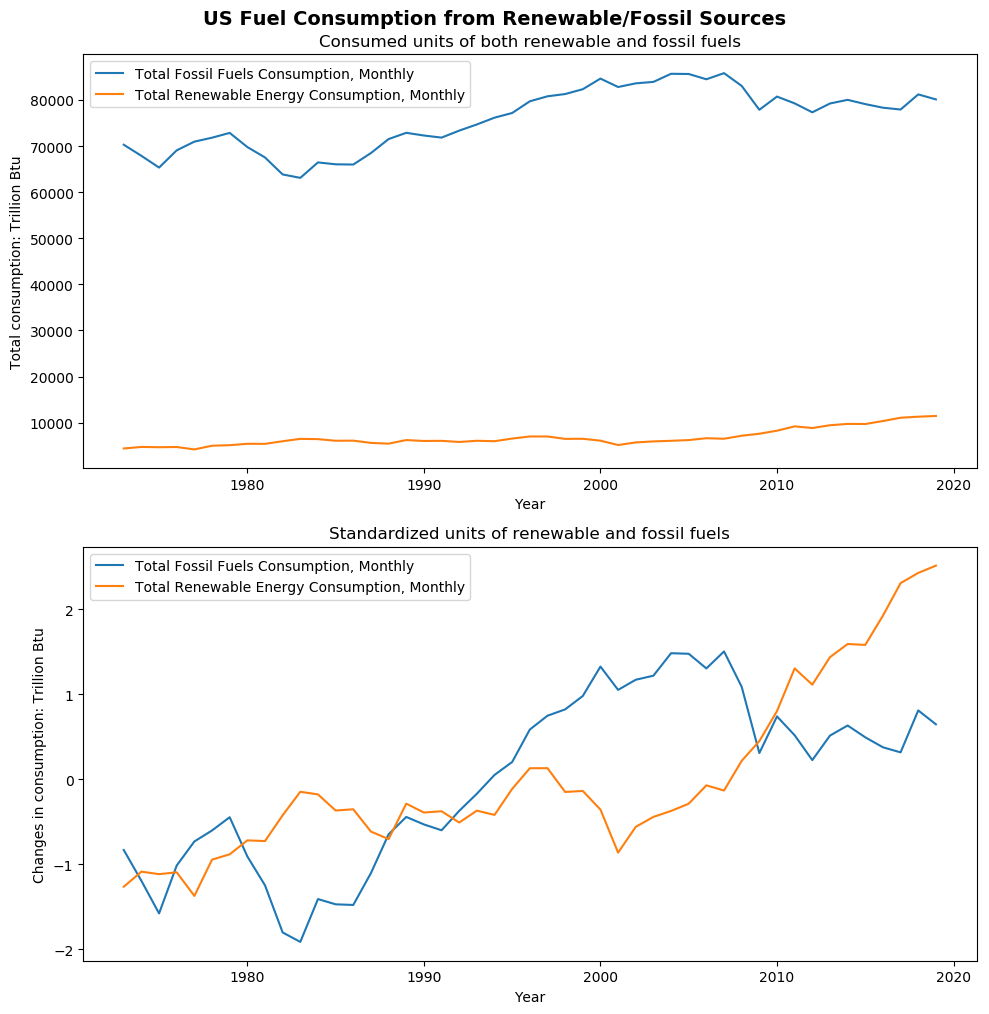

In [187]:
#Extract units
#Units are the same for both energy measurements
#So we only need the units from one JSON header
units = JSONheadersEIA(fossilFuelGeneric)['units']

#Overall graph properties
figure, (axisTop, axisBottom) = matplotlib.pyplot.subplots(2, figsize=(10, 10), dpi=100)
figure.suptitle('US Fuel Consumption from Renewable/Fossil Sources', 
                fontsize=14, 
                fontweight='bold',
               y=1.01)

#Top Chart attributes
legendTop = axisTop.plot(pivotFuelData)
axisTop.set_title("Consumed units of both renewable and fossil fuels")
axisTop.set_ylabel(str('Total consumption: '+units))
axisTop.set_xlabel('Year')

#Bottom Chart attributes
legendBottom = axisBottom.plot(standardizeDataFrame(pivotFuelData))
axisBottom.set_title("Standardized units of renewable and fossil fuels")
axisBottom.set_ylabel(str('Changes in consumption: '+units))
axisBottom.set_xlabel('Year')

#Spacing adjustment
#figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
figure.tight_layout()
legendLabels = pivotFuelData.columns
axisTop.legend(legendTop, legendLabels)
axisBottom.legend(legendBottom, legendLabels)